In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
#drive.mount('/content/drive')
from sklearn.cluster import KMeans
from concurrent.futures import ProcessPoolExecutor
import functools
from sklearn.metrics import silhouette_samples , silhouette_score
import matplotlib.pyplot as plt

In [2]:
from itertools import islice

def model_w_parameters(alpha, beta, gamma, data):
    """
    Apply exponential smoothing with damped trend method.
    Returns one-step-ahead forecasts for given data.
    """
    observation = data.values  # Convert to numpy array for speed
    levels = [observation[0]]
    slopes = [(observation[0] - observation[-1]) / len(observation)]
    forecasts = np.zeros(len(observation))

    for i, o in enumerate(observation):
        level_value = o * alpha + (gamma * slopes[i] + levels[i]) * (1 - alpha)
        levels.append(level_value)
        slopes.append((level_value - levels[i]) * beta + (1 - beta) * gamma * slopes[i])
        forecasts[i] = levels[i] + gamma * slopes[i]

    return forecasts, slopes[-1]

def calculate_mape(params, dataframe, colnames):
    """Calculate MAPE for given parameters across all columns"""
    alpha, beta, gamma = params
    forecasts_list = []

    for colname in colnames:
        forecasts, _ = model_w_parameters(alpha, beta, gamma, dataframe[colname])
        forecasts_list.append(forecasts)

    mapes = []
    for i, colname in enumerate(colnames):
        actual = dataframe[colname].values
        forecast = forecasts_list[i]
        # Avoid division by zero
        valid_indices = actual != 0
        if np.any(valid_indices):
            mape = np.mean(np.abs((actual[valid_indices] - forecast[valid_indices]) / actual[valid_indices]) * 100)
            mapes.append(mape)

    return np.mean(mapes) if mapes else float('inf')

def optimizer_in_clusters(dataframe, n_jobs=-1, grid_sizes=(10, 5, 3)):
    """
    Optimized version that uses grid search with adaptive refinement and parallel processing.

    Args:
        dataframe: Input dataframe with time series columns
        n_jobs: Number of parallel jobs to run (-1 for all cores)
        grid_sizes: Tuple of grid sizes for each refinement level

    Returns:
        Optimal alpha, beta, gamma parameters and the minimum MAPE
    """
    colnames = dataframe.columns[1:] if len(dataframe.columns) > 1 else dataframe.columns

    # Initial grid search with fewer points
    best_params = None
    best_mape = float('inf')

    # Create parameter combinations for initial grid
    n1 = grid_sizes[0]
    param_grid = []
    for a in np.linspace(0.01, 0.99, n1):
        for b in np.linspace(0.01, 0.99, n1):
            for g in np.linspace(0.05, 0.95, n1): #gamma restricted olanda burası değişecek.
                param_grid.append((a, b, g))

    # Initial search with parallel processing
    with ProcessPoolExecutor(max_workers=n_jobs) as executor:
        mape_func = functools.partial(calculate_mape, dataframe=dataframe, colnames=colnames)
        results = list(executor.map(mape_func, param_grid))

    # Find best result from initial grid
    best_idx = np.argmin(results)
    best_params = param_grid[best_idx]
    best_mape = results[best_idx]

    # Refine search around best parameters, using smaller grid size each time
    for grid_size in grid_sizes[1:]:
        alpha_best, beta_best, gamma_best = best_params
        param_grid = []

        # Create refined grid around best parameters
        alpha_range = np.linspace(max(0.01, alpha_best - 0.05), min(0.99, alpha_best + 0.05), grid_size)
        beta_range = np.linspace(max(0.01, beta_best - 0.05), min(0.99, beta_best + 0.05), grid_size)
        gamma_range = np.linspace(max(0.05, gamma_best - 0.05), min(0.95, gamma_best + 0.05), grid_size) # gamma restricted olacaksa burası değişecek.

        for a in alpha_range:
            for b in beta_range:
                for g in gamma_range:
                    param_grid.append((a, b, g))

        # Refined search with parallel processing
        with ProcessPoolExecutor(max_workers=n_jobs) as executor:
            mape_func = functools.partial(calculate_mape, dataframe=dataframe, colnames=colnames)
            results = list(executor.map(mape_func, param_grid))

        # Update best parameters
        best_idx = np.argmin(results)
        best_params = param_grid[best_idx]
        best_mape = results[best_idx]

    return best_params[0], best_params[1], best_params[2], best_mape
def forecaster_clustered(test_data ,train_data , optimizing_parameters , step = 2 , reason = 'test'):
  alp,bet,gam = optimizing_parameters
  columns = train_data.columns
  slopes = [model_w_parameters(alp,bet,gam ,train_data[column])[1] for column in columns]
  dftest = test_data
  dftrain = train_data
  h = step

  if reason == 'test':
    h = len(dftest)
    d_values = [np.array([gam**k for k in range(1, h + 1) ]) for i in range(len(columns))]
    forecasts = [[dftest[d].iloc[0] + slopes[i] * (d_values[i][:p]).sum() for p in range(1,h+1)] for i,d in enumerate(columns)]
  else:
    d_values = [np.array([gam**k for k in range(1, h + 1) ]) for i in range(len(columns))]
    forecasts = [[dftest[d].iloc[-1] + slopes[i] * (d_values[i][:p]).sum() for p in range(1,h+1)] for i,d in enumerate(columns)]
  return forecasts
def get_cluster_numbers(path):
  df = pd.read_excel(path).iloc[:,1:]
  dfnew = df.transpose()
  dfnew = dfnew.reset_index()
  dfnew.columns = ['ZoneId'] + [a for a in df['date']]
  dfnew = dfnew.iloc[1:,:]
  dfcluster = dfnew
  data = dfcluster.iloc[0:,1:]
  inertias = []
  silhouettes = []
  for i in range(2,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)
    labels = kmeans.fit_predict(data)
    silhouette_avg = silhouette_score(data , labels)
    silhouettes.append(silhouette_avg)
  kmean_silhouettes = pd.DataFrame({'num_clusters': [*range(2,11)], 'silhouette_scores':silhouettes})
  plt.plot(range(2,11), inertias, marker='o')
  plt.title('Elbow method')
  plt.xlabel('Number of clusters')
  plt.ylabel('Inertia')
  plt.show()
  cluster_numbers = kmean_silhouettes.sort_values(by='silhouette_scores',ascending=False).iloc[:3,0]
  return cluster_numbers
def info_gatherer(path , cluster_numbers ):
  df = pd.read_excel(path).iloc[:,1:]
  dftrain = df.iloc[:14,:]
  dftest = df.iloc[14:,:]
  dfnew = df.transpose()
  dfnew = dfnew.reset_index()
  dfnew.columns = ['ZoneId'] + [a for a in df['date']]
  dfnew = dfnew.iloc[1:,:]
  dfcluster = dfnew
  data = dfcluster.iloc[0:,1:]
  label_dict = {}
  for n in cluster_numbers:

    for i in range(n):
      key = str(n) +'_clusters'
      kmeans = KMeans(n_clusters=n)
      kmeans.fit(data)
      labels = kmeans.fit_predict(data)
      label_dict[key] = labels
  zone_names_dict = {}
  models = {}
  errors = {}
  for element in label_dict:
    data[element] = label_dict[element]
    zone_names_dict[element] = {}
    models[element] = {}
    errors[element] = {}
    for cluster in data[element].unique():
      zone_names_dict[element][str(cluster)] = dfcluster[data[element] == cluster]['ZoneId']
      models[element][str(cluster)] = optimizer_in_clusters(dftrain[zone_names_dict[element][str(cluster)]],8)
      alp , bet , gam , _ = models[element][str(cluster)]
      forecastsList = forecaster_clustered(dftest[zone_names_dict[element][str(cluster)]],dftrain[zone_names_dict[element][str(cluster)]],(alp,bet,gam),reason='test')
      mape_list = []
      mae_list = []
      mse_list = []

      for i,e in enumerate(zone_names_dict[element][str(cluster)]) :
        forecasted_value_column = e+'_forecasted'
        error_column = e + '_error_term'
        dftest[forecasted_value_column] = forecastsList[i]
        dftest[error_column] = dftest[e] - dftest[forecasted_value_column]
        mape_list.append(((abs(dftest[error_column]/dftest[e]))*100).mean())
        mae_list.append(abs(dftest[error_column]).mean())
        mse_list.append((dftest[error_column]**2).mean())
      errors[element][str(cluster)] = {'mape_list':mape_list , 'mae_list':mae_list , 'mse_list':mse_list}
  return zone_names_dict , models , errors


def writer(zone_info , parameter_info , error_info ,root  , ilce ,column_order ):
  for elements in zone_info:
    dict_of_lists = {'ZoneId': [] , 'alpha' : [] , 'beta': [] , 'gamma': [] , 'train_mape' : [] , 'test_mape' : [] , 'test_mse' :[] , 'test_mae' : [] }
    for cluster_number in zone_info[elements]:
      for i , zone in enumerate(zone_info[elements][cluster_number]):
        dict_of_lists['ZoneId'].append(zone)
        dict_of_lists['alpha'].append(parameter_info[elements][cluster_number][0])
        dict_of_lists['beta'].append(parameter_info[elements][cluster_number][1])
        dict_of_lists['gamma'].append(parameter_info[elements][cluster_number][2])
        dict_of_lists['train_mape'].append(parameter_info[elements][cluster_number][3])
        dict_of_lists['test_mape'].append(error_info[elements][cluster_number]['mape_list'][i])
        dict_of_lists['test_mae'].append(error_info[elements][cluster_number]['mae_list'][i])
        dict_of_lists['test_mse'].append(error_info[elements][cluster_number]['mse_list'][i])
    df = pd.DataFrame(dict_of_lists)
    df = df.set_index('ZoneId')
    df = df.loc[column_order]
    df.to_excel(root + '/' + ilce + '/' + ilce + '_' + elements + '_errors_params-50.xlsx')
def clustered_info_to_excel(izmir_poligon_path , ilce):
  path = izmir_poligon_path + '/' + ilce + '/' + ilce + '_meandata-50.xlsx'
  cluster_numbers = get_cluster_numbers(path)
  zones , models , errors = info_gatherer(path , cluster_numbers)
  writer(zones , models , errors , izmir_poligon_path , ilce , pd.read_excel(path).iloc[:,2:].columns)

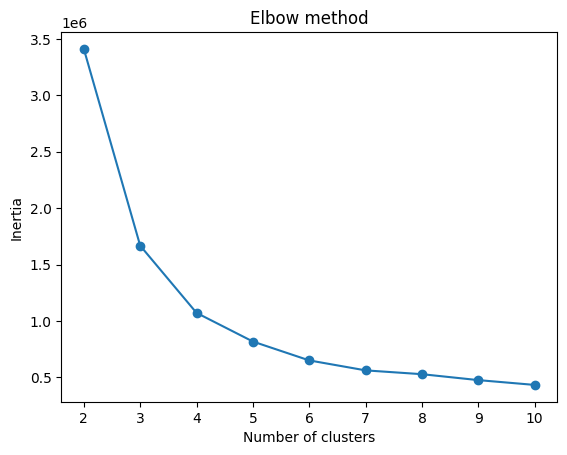

Görüntülenen çıkış son 5000 satıra kısaltıldı.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftest[error_column] = dftest[e] - dftest[forecasted_value_column]
<ipython-input-2-5a5196cc12fd>:184: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dftest[forecasted_value_column] = forecastsList[i]
<ipython-input-2-5a5196cc12fd>:184: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

In [3]:
izmir_poligon_path = '/content'
ilce = 'all'
clustered_info_to_excel(izmir_poligon_path,ilce)